In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift


Known offset (y, x): (-22.4, 13.32, 0)


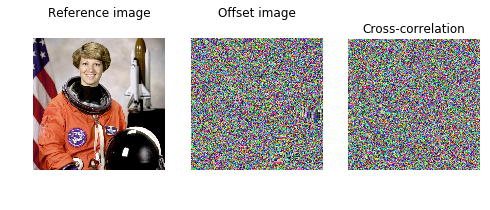

In [12]:
image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print("Known offset (y, x): {}".format(shift))

#image = 

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()



In [8]:
print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

Detected pixel offset (y, x): [ 22. -13.   0.]


NotImplementedError: Error: register_translation only supports subpixel registration for 2D images